#Описание модели

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
# Линейный слой
class LinearLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, 1.0 / np.sqrt(input_size), (input_size, output_size))
        self.biases = np.zeros((1, output_size))

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# Функции активации
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))

class Softmax:

    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        return probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

# Функции потерь
class MeanSquaredError:
  def forward(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return np.mean((y_pred - y_true) ** 2)

  def backward(self, dvalues):
    self.dinputs = 2 * (self.y_pred - self.y_true) / self.y_pred.size

class BinaryCrossEntropy:
    def forward(self, y_pred, y_true):
        self.y_true = y_true
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        return np.mean(sample_losses)

    def backward(self, dvalues):
        y_pred_clipped = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -(self.y_true / y_pred_clipped - (1 - self.y_true) / (1 - y_pred_clipped)) / dvalues.size

class CategoricalCrossEntropy:
    def forward(self, y_pred, y_true):
        self.y_true = y_true
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -np.sum(self.y_true * np.log(y_pred_clipped), axis=1)
        return np.mean(sample_losses)

    def backward(self, dvalues):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(self.y_true.shape) == 1:
            y_true = np.eye(labels)[self.y_true]
        else:
            y_true = self.y_true

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples



In [3]:
#Оптимизаторы
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_weights = {}
        self.velocity_biases = {}

    def update_params(self, layer):
        if layer not in self.velocity_weights:
            self.velocity_weights[layer] = np.zeros_like(layer.weights)
            self.velocity_biases[layer] = np.zeros_like(layer.biases)

        self.velocity_weights[layer] = self.momentum * self.velocity_weights[layer] - self.learning_rate * layer.dweights
        self.velocity_biases[layer] = self.momentum * self.velocity_biases[layer] - self.learning_rate * layer.dbiases

        layer.weights += self.velocity_weights[layer]
        layer.biases += self.velocity_biases[layer]

In [4]:
# Модель
class Model:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        output = inputs
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, dvalues):
        for layer in reversed(self.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

    def update_params(self, optimizer):
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                optimizer.update_params(layer)


In [5]:
# Функция обучения модели
def train_model(model, X_train, X_test, y_train, y_test, loss_function, optimizer, metric, epochs=100, batch_size=32):

    steps_per_epoch = len(X_train) // batch_size

    history = {
        'train_loss': [],
        'test_loss': [],
        'test_metric': []
    }

    # Цикл обучения
    for epoch in range(epochs):
        # Перемешивание данных
        X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            # Выбор мини-батча
            batch_start = step * batch_size
            batch_end = (step + 1) * batch_size
            X_batch = X_train_shuffled[batch_start:batch_end]
            y_batch = y_train_shuffled[batch_start:batch_end]

            # Прямой проход
            output = model.forward(X_batch)

            loss = loss_function.forward(output, y_batch)
            epoch_loss += loss

            # Обратное распространение
            loss_function.backward(output)
            model.backward(loss_function.dinputs)

            # Обновление параметров
            model.update_params(optimizer)


        epoch_loss /= steps_per_epoch
        history['train_loss'].append(epoch_loss)

        # Оценка на тестовой выборке
        test_output = model.forward(X_test)
        test_loss = loss_function.forward(test_output, y_test)
        test_metric_value = metric(y_test, test_output)
        history['test_loss'].append(test_loss)
        history['test_metric'].append(test_metric_value)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {epoch_loss:.3f}, Test Loss: {test_loss:.3f}, Test Metric: {test_metric_value:.3f}')

    return model, history


#Решение задачи регрессии

Апроксимируем функцию $y = \sin(\sin(x^2)) + \cos(\cos(x))$

Epoch 0, Train Loss: 1.748, Test Loss: 1.972, Test Metric: 1.972
Epoch 10, Train Loss: 0.437, Test Loss: 0.500, Test Metric: 0.500
Epoch 20, Train Loss: 0.374, Test Loss: 0.474, Test Metric: 0.474
Epoch 30, Train Loss: 0.367, Test Loss: 0.366, Test Metric: 0.366
Epoch 40, Train Loss: 0.355, Test Loss: 0.357, Test Metric: 0.357
Epoch 50, Train Loss: 0.328, Test Loss: 0.367, Test Metric: 0.367
Epoch 60, Train Loss: 0.312, Test Loss: 0.362, Test Metric: 0.362
Epoch 70, Train Loss: 0.302, Test Loss: 0.365, Test Metric: 0.365
Epoch 80, Train Loss: 0.295, Test Loss: 0.362, Test Metric: 0.362
Epoch 90, Train Loss: 0.290, Test Loss: 0.356, Test Metric: 0.356
Epoch 100, Train Loss: 0.287, Test Loss: 0.355, Test Metric: 0.355
Epoch 110, Train Loss: 0.283, Test Loss: 0.355, Test Metric: 0.355
Epoch 120, Train Loss: 0.279, Test Loss: 0.357, Test Metric: 0.357
Epoch 130, Train Loss: 0.274, Test Loss: 0.374, Test Metric: 0.374
Epoch 140, Train Loss: 0.269, Test Loss: 0.380, Test Metric: 0.380
Epoch 

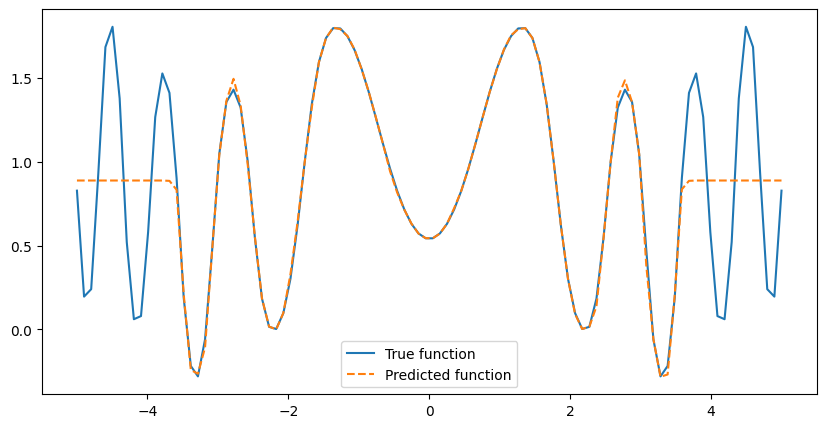

In [6]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(np.sin(X ** 2)) + np.cos(np.cos(X))

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Model()
model.add(LinearLayer(1, 128))
model.add(ReLU())
model.add(LinearLayer(128, 64))
model.add(ReLU())
model.add(LinearLayer(64, 32))
model.add(Sigmoid())
model.add(LinearLayer(32, 1))
# Функция потерь
loss_function = MeanSquaredError()

# Оптимизатор
optimizer = Momentum(learning_rate=0.1)

# Метрика - в данном случае используем MSE как метрику
metric = mean_squared_error

# Обучение модели
trained_model, history = train_model(
    model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    loss_function,
    optimizer,
    metric,
    epochs=8000,
    batch_size=80
)

# Вывод информации о обучении
print(f"Final Train Loss: {history['train_loss'][-1]:.3f}")
print(f"Final Test Loss: {history['test_loss'][-1]:.3f}")
print(f"Final Test MSE: {history['test_metric'][-1]:.3f}")

# Предсказание для визуализации
y_pred = model.forward(scaler.transform(X))

plt.figure(figsize=(10, 5))
plt.plot(X, y, label='True function')
plt.plot(X, y_pred.flatten(), label='Predicted function', linestyle='--')
plt.legend()
plt.show()

#Решение задачи бинарной классификации

Загрузим данные UCI Adult Dataset. Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [7]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-09-11 13:56:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [     <=>            ]   3.79M  3.10MB/s    in 1.2s    

2024-09-11 13:56:59 (3.10 MB/s) - ‘adult.data’ saved [3974305]



In [8]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14143,28,Private,190525,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,46,United-States,1


In [9]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


In [11]:
df.nunique()

,0
age,73
workclass,9
fnlwgt,21648
education,16
education-num,16
marital-status,7
occupation,15
relationship,6
race,5
sex,2


In [12]:
numeric = ['capital-gain', 'age', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week']

In [13]:
categorcal = list(set(df.columns) - set(numeric) - {'income'})
categorcal

['workclass',
 'native-country',
 'occupation',
 'sex',
 'marital-status',
 'relationship',
 'education',
 'race']

In [14]:
df_encoded = pd.get_dummies(df, columns=categorcal)
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,38,215646,9,0,0,40,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,53,234721,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
32557,40,154374,9,0,0,40,1,False,False,False,...,True,False,False,False,False,False,False,False,False,True
32558,58,151910,9,0,0,40,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
32559,22,201490,9,0,0,20,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [15]:
scaler = StandardScaler()
df_encoded[numeric] = scaler.fit_transform(df_encoded[numeric])

In [16]:
y = df_encoded['income']
X = df_encoded.drop(columns=['income'])

In [17]:
X.shape

(32561, 108)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [19]:
Classifier = Model()
Classifier.add(LinearLayer(108, 16))
Classifier.add(ReLU())
Classifier.add(LinearLayer(16, 1))
Classifier.add(Sigmoid())

In [20]:
y_test.mean()

0.2407566638005159

In [21]:
X_train.shape

(24420, 108)

In [22]:
y_train.shape

(24420,)

In [23]:
# Функция потерь
loss_function = BinaryCrossEntropy()

# Оптимизатор
optimizer = Momentum(learning_rate=0.1)


def accuracy_metric(y_true, y_pred):
    y_pred_rounded = (y_pred > 0.5).astype(int)
    return accuracy_score(y_true, y_pred_rounded)

metric = accuracy_metric

# Обучение модели
trained_model, history = train_model(
    Classifier,
    X_train.to_numpy(dtype=float),
    X_test.to_numpy(dtype=float),
    y_train.to_numpy().reshape(-1, 1),
    y_test.to_numpy().reshape(-1, 1),
    loss_function,
    optimizer,
    metric,
    epochs=50,
    batch_size=128
)

# Вывод информации о обучении
print(f"Final Train Loss: {history['train_loss'][-1]:.3f}")
print(f"Final Test Loss: {history['test_loss'][-1]:.3f}")
print(f"Final Test accuracy: {history['test_metric'][-1]:.3f}")


Epoch 0, Train Loss: 0.347, Test Loss: 0.320, Test Metric: 0.851
Epoch 10, Train Loss: 0.300, Test Loss: 0.312, Test Metric: 0.855
Epoch 20, Train Loss: 0.296, Test Loss: 0.319, Test Metric: 0.853
Epoch 30, Train Loss: 0.291, Test Loss: 0.313, Test Metric: 0.856
Epoch 40, Train Loss: 0.287, Test Loss: 0.312, Test Metric: 0.856
Final Train Loss: 0.285
Final Test Loss: 0.315
Final Test accuracy: 0.858
